# Tweaking CNN Parameters
## Preface
To explore the CNN inner workings a bit more, I want to use this post to tweak some parameters and see how that impacts the filters that were learned by the TFlearn model. Off the top of my naive head, I can think of a few parameters in our CNN that can be optimized:
- Number of convolutional layers
- Filter size of convolutional layers
- Number of filters in each convolutional layer
- Presence of max pooling layers
- Size of max pooling
- Number of nodes in the fully connected layer

Because I'm going to aim to train a few different models, I'm back on AWS so I don't have to wait 5 minutes per model.

I'll probably start by tweaking the convolutional layers and go from there.

In [1]:
# Install tflearn
import os
os.system("sudo pip install tflearn")

0

## Feature Building

In [51]:
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Temporarily load from np arrays
chi_photos_np = np.load('chi_photos_np_0.03_compress.npy')
lars_photos_np = np.load('lars_photos_np_0.03_compress.npy')

In [4]:
# View shape of numpy array
chi_photos_np.shape

(203, 91, 91)

In [5]:
# Set width var
width = chi_photos_np.shape[-1]
width

91

## Scaling Inputs

In [6]:
# Try out scaler on a manually set data (min of 0, max of 255)
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Set test data list to train on (min of 0, max of 255)
test_list = np.array([0, 255]).reshape(-1, 1)
test_list

array([[  0],
       [255]])

In [8]:
# Initialize scaler
scaler = MinMaxScaler()

In [9]:
# Fit test list
scaler.fit(test_list)

/usr/lib64/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

## Reshaping 3D Array To 4D Array

In [10]:
chi_photos_np.reshape(-1, width, width, 1).shape

(203, 91, 91, 1)

## Putting It All Together

In [11]:
# Reshape to prepare for scaler
chi_photos_np_flat = chi_photos_np.reshape(1, -1)
chi_photos_np_flat[:10]

array([[135, 139, 139, ..., 210, 142, 136]], dtype=uint8)

In [12]:
# Scale
chi_photos_np_scaled = scaler.transform(chi_photos_np_flat)
chi_photos_np_scaled[:10]

array([[ 0.52941176,  0.54509804,  0.54509804, ...,  0.82352941,
         0.55686275,  0.53333333]])

In [13]:
# Reshape to prepare for scaler
lars_photos_np_flat = lars_photos_np.reshape(1, -1)
lars_photos_np_scaled = scaler.transform(lars_photos_np_flat)

In [14]:
# Reshape
chi_photos_reshaped = chi_photos_np_scaled.reshape(-1, width, width, 1)
lars_photos_reshaped = lars_photos_np_scaled.reshape(-1, width, width, 1)

print('{} has shape: {}'. format('chi_photos_reshaped', chi_photos_reshaped.shape))
print('{} has shape: {}'. format('lars_photos_reshaped', lars_photos_reshaped.shape))

chi_photos_reshaped has shape: (203, 91, 91, 1)
lars_photos_reshaped has shape: (200, 91, 91, 1)


In [15]:
# Create copy of chi's photos to start populating x_input
x_input = copy.deepcopy(chi_photos_reshaped)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (203, 91, 91, 1)


In [16]:
# Concatentate lars' photos to existing x_input
x_input = np.append(x_input, lars_photos_reshaped, axis = 0)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (403, 91, 91, 1)


## Preparing Labels

In [17]:
# Create label arrays
y_chi = np.array([[1, 0] for i in chi_photos_reshaped])
y_lars = np.array([[0, 1] for i in lars_photos_reshaped])

print('{} has shape: {}'. format('y_chi', y_chi.shape))
print('{} has shape: {}'. format('y_lars', y_lars.shape))

y_chi has shape: (203, 2)
y_lars has shape: (200, 2)


In [18]:
# Preview the first few elements
y_chi[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [19]:
y_lars[:5]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [20]:
# Create copy of chi's labels to start populating y_input
y_input = copy.deepcopy(y_chi)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (203, 2)


In [21]:
# Concatentate lars' labels to existing y_input
y_input = np.append(y_input, y_lars, axis = 0)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (403, 2)


## CNN \#1 - Less Convolutional Filters
I want to try less convolutional filters because looking at 2048 filters on one graph is a bit much haha, a bit hard to tell exactly what's going on.

If I use 3 filters in each layer of our CNN, I should get a stack of 3 convolutional outputs after conv layer 1, and 9 convolutional outputs after conv layer 2. Hopefully that will be a bit easier on the eyes.

In [22]:
# TFlearn libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [23]:
# sentdex's code to build the neural net using tflearn
#   Input layer --> conv layer w/ max pooling --> conv layer w/ max pooling --> fully connected layer --> output layer
convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_1')
convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_2')
convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
convnet = dropout(convnet, 0.8, name = 'dropout_1')

convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')

### Train Test Split

In [24]:
# Import library
from sklearn.model_selection import train_test_split

In [25]:
print(x_input.shape)
print(y_input.shape)

(403, 91, 91, 1)
(403, 2)


In [37]:
# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size = 0.1, stratify = y_input)

x_train = np.array(x_train, dtype = np.float64)
x_test = np.array(x_test, dtype = np.float64)
y_train = np.array(y_train, dtype = np.float64)
y_test = np.array(y_test, dtype = np.float64)

### Training

In [27]:
# Train with data
model = tflearn.DNN(convnet)
model.fit(
    {'input': x_train},
    {'targets': y_train},
    n_epoch = 10,
    validation_set = ({'input': x_test}, {'targets': y_test}),
    snapshot_step = 500,
    show_metric = True
)

Training Step: 59  | total loss: 0.49119 | time: 0.104s
| SGD | epoch: 010 | loss: 0.49119 - acc: 0.9678 -- iter: 320/362
Training Step: 60  | total loss: 0.47759 | time: 1.129s
| SGD | epoch: 010 | loss: 0.47759 - acc: 0.9720 | val_loss: 0.31636 - val_acc: 1.0000 -- iter: 362/362
--


### View Convolutional Filters

In [54]:
import six

def display_convolutions(model, layer, padding=4, filename=''):
    if isinstance(layer, six.string_types):
        vars = tflearn.get_layer_variables_by_name(layer)
        variable = vars[0]
    else:
        variable = layer.W

    data = model.get_weights(variable)

    # N is the total number of convolutions
    N = data.shape[2] * data.shape[3]
    print('There are {} filters in {}'.format(N, layer))

    # Ensure the resulting image is square
    filters_per_row = int(np.ceil(np.sqrt(N)))
    # Assume the filters are square
    filter_size = data.shape[0]
    # Size of the result image including padding
    result_size = filters_per_row * (filter_size + padding) - padding
    # Initialize result image to all zeros
    result = np.zeros((result_size, result_size))

    # Tile the filters into the result image
    filter_x = 0
    filter_y = 0
    for n in range(data.shape[3]):
        for c in range(data.shape[2]):
            if filter_x == filters_per_row:
                filter_y += 1
                filter_x = 0
            for i in range(filter_size):
                for j in range(filter_size):
                    result[filter_y * (filter_size + padding) + i, filter_x * (filter_size + padding) + j] = \
                        data[i, j, c, n]
            filter_x += 1

    # Normalize image to 0-1
    min = result.min()
    max = result.max()
    result = (result - min) / (max - min)

    # Plot figure
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(result, cmap='gray', interpolation='nearest')

    # Save plot if filename is set
    if filename != '':
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()

There are 3 filters


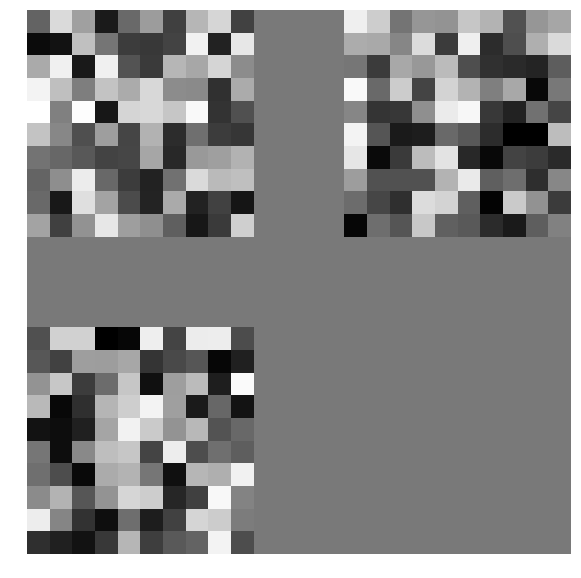

In [29]:
# Display first convolutional layer filters
display_convolutions(model, 'conv_1')

There are 9 filters


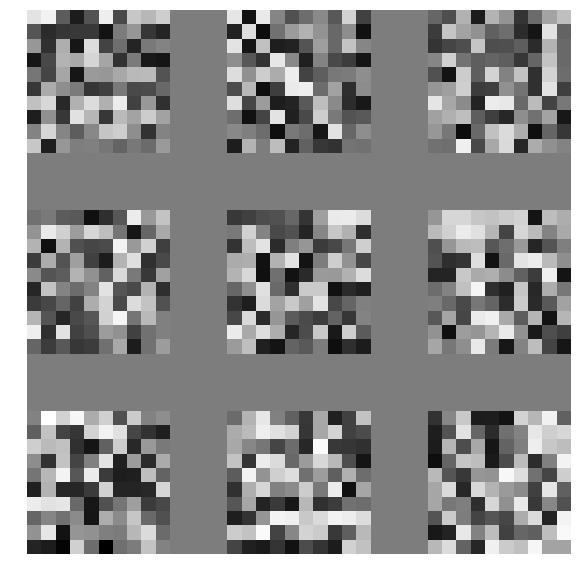

In [30]:
# Display first convolutional layer filters ( filters)
display_convolutions(model, 'conv_2')

Hmm... they could _**potentially**_ represent some part of someone's face, but it's still a bit too pixelated to tell... What if I go smaller filter size?

## CNN \#2 - Smaller Filter Sizes
I used a 10 x 10 filter in each of the layers... let's go down to a... I dunno, maybe 3 x 3 just for fun?

Training Step: 35  | total loss: 0.24660 | time: 0.105s
| SGD | epoch: 006 | loss: 0.24660 - acc: 0.9924 -- iter: 320/362
Training Step: 36  | total loss: 0.23037 | time: 1.132s
| SGD | epoch: 006 | loss: 0.23037 - acc: 0.9940 | val_loss: 0.14065 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


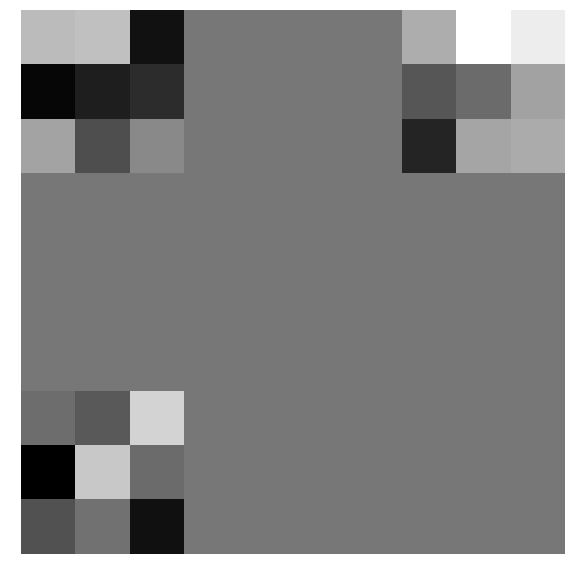

There are 9 filters in conv_2


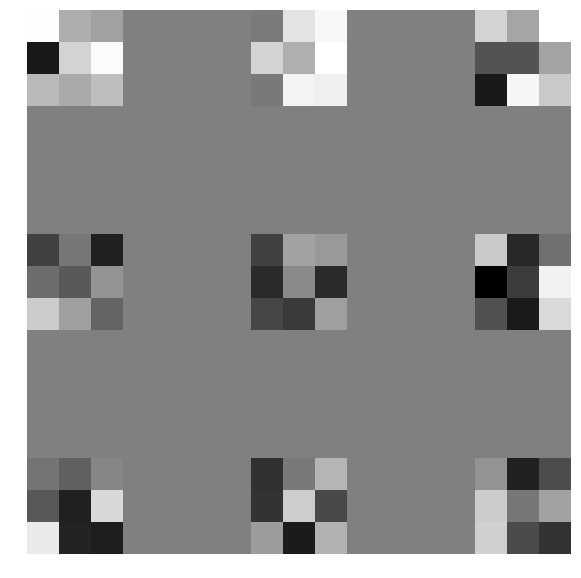

In [61]:
import tensorflow as tf

with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')

First of all, I had to import tensorflow and add in

~~~~
with tf.Graph().as_default():
~~~~

to somehow separate the new model into another "graph session". What are these? I'm not sure, but this [stack overflow inquiry](https://stackoverflow.com/questions/39887397/how-to-use-two-nets-in-tflearn?rq=1) helped me out a bit. With that, I got my new model training with the same variable names where it was giving me an error earlier.

I trained the model until 6 epochs because that's when I saw accuracy peak. A manual early stopping mechanism, if you will. Even with 6 epochs and only 3 x 3 filters with 3 filters per convolutional layer, we still reach 99% accuracy!

Again, the filters don't quite mean anything to me (I'm not sure it _**can**_ mean anything being 3 pixels by 3 pixels), but I do see some generally brighter colored filters and darker colored filters... perhaps these could represent the face / background and hair respectively!

Let's try going the other way and making huge filters... why not just cover the entire photo... let's try it out.

## CNN \#3 - Larger Filter Sizes
Let's just use a 91 x 91 filter and see what happens. Maybe this will lend itself to a recognizable filter a bit more.

Training Step: 35  | total loss: 0.02995 | time: 0.274s
| SGD | epoch: 006 | loss: 0.02995 - acc: 0.9960 -- iter: 320/362
Training Step: 36  | total loss: 0.02508 | time: 1.338s
| SGD | epoch: 006 | loss: 0.02508 - acc: 0.9968 | val_loss: 0.00428 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


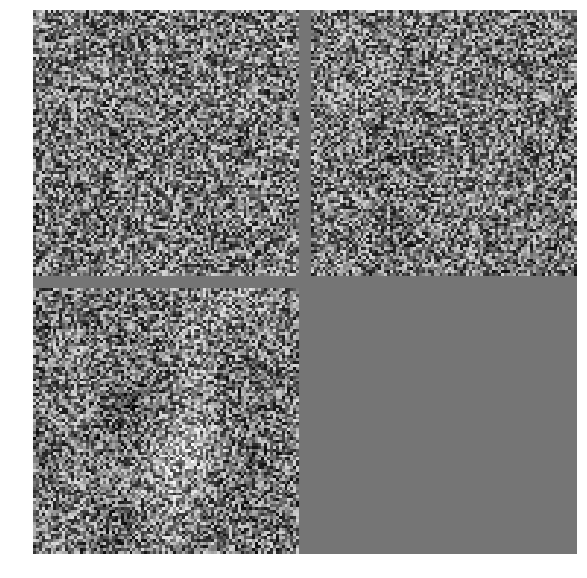

There are 9 filters in conv_2


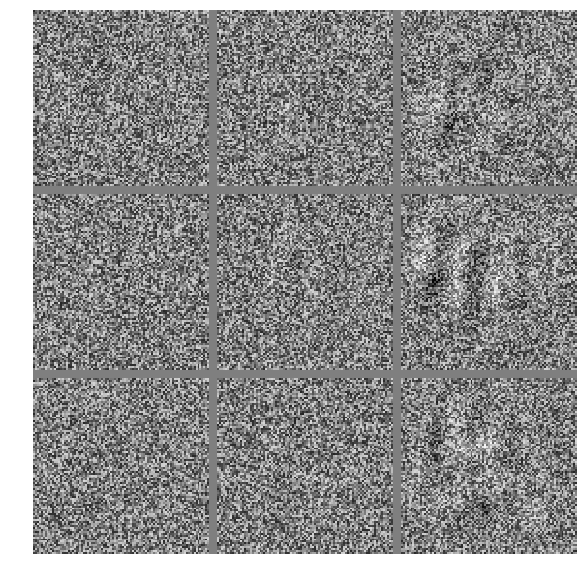

In [65]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')

Interesting, it still doesn't quite make sense to me, but it's starting to take some type of shape in the second level filters. In that bottom right one in the second layer filters, I can almost even see a face if I squint... Or maybe that's just my hope and dreams deceiving my eyes right before me. It's plausible that one of these should / may have the silhouette of a person because my filter size is the size of the entire image. There theoretically isn't even any strides happening here.

Let's try 3 layers to see what kind of difference that makes.

## CNN \#4 - More convolutional layers

Training Step: 59  | total loss: 0.57988 | time: 0.468s
| SGD | epoch: 010 | loss: 0.57988 - acc: 0.9800 -- iter: 320/362
Training Step: 60  | total loss: 0.54609 | time: 1.578s
| SGD | epoch: 010 | loss: 0.54609 - acc: 0.9826 | val_loss: 0.11427 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


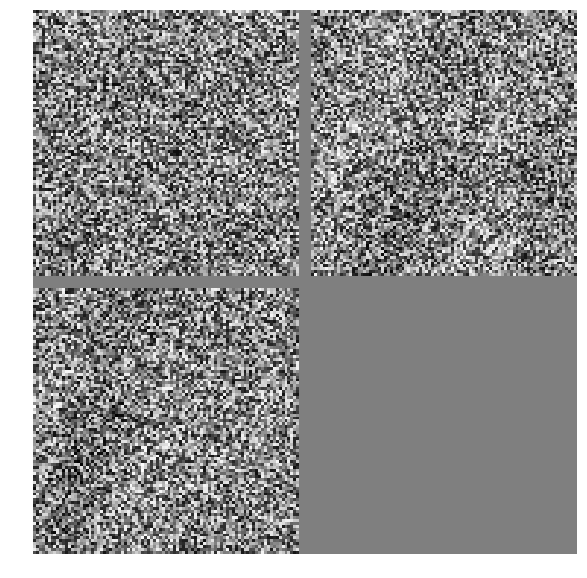

There are 9 filters in conv_2


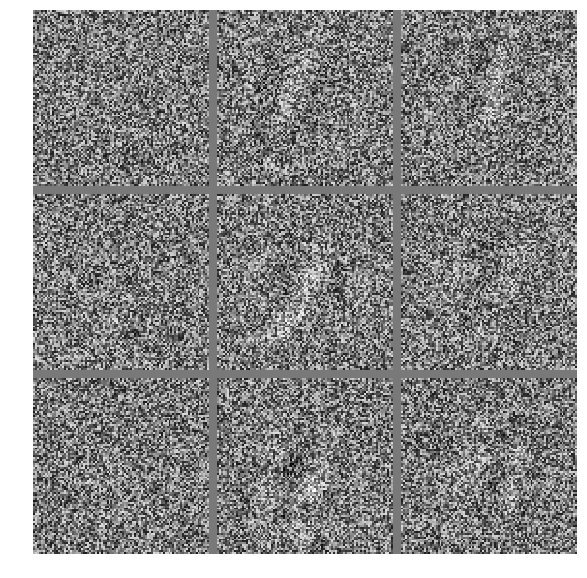

There are 9 filters in conv_3


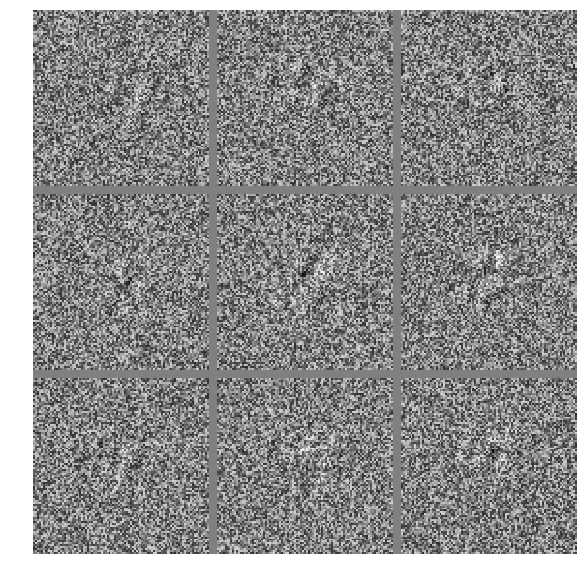

In [67]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')
    
    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_3')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_3')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 10,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')
    display_convolutions(model, 'conv_3')

Hmm... first thought: Why are there only 9 filters in convolutional layer 3?

### Layer 1
- Input: A stack with 1 image
- Output: A stack with 3 images (each image in the stack is convoluted with 3 filters)

### Layer 2
- Input: A stack with 3 images
- Output: A stack with 9 images (each image in the stack is convoluted with 3 filters)

### Layer 3
- Input: A stack with 9 images
- Output: A stack with 27 images (each image in the stack is convoluted with 3 filters)